# Prediction Weights

This notebook investigates the weights of features used in the model.

The data used is that from the following paper:

[Compact and highly active next-generation libraries for CRISPR-mediated gene repression and activation](https://elifesciences.org/articles/19760)

__Authors__: Anthony Hein, Briana Macedo

---

## Imports and Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re

In [2]:
plt.rcParams.update({'font.size': 12})

---

## Load Coefficients and Dataframe

In [3]:
coef = np.load('coef_elastic.npy')
coef[1, :] = coef[0, :] - coef[1, :]
coef[2, :] = coef[2, :] - coef[0, :]
print(coef[0:5])
print(coef.shape)

[[ 0.00394976  0.          0.         ... -0.00049359 -0.00348531
  -0.00332801]
 [ 0.00134026  0.          0.         ...  0.00059115  0.00188506
   0.00050269]
 [ 0.00120674  0.          0.         ...  0.00049359  0.00227078
   0.00056751]]
(3, 601)


In [4]:
features_df = pd.read_csv("features_binned.csv")
features_df = features_df.drop(columns=["Unnamed: 0"])
cols = features_df.columns
cols

Index(['+ve strand', 'pos_-27_A', 'pos_-27_C', 'pos_-27_G', 'pos_-27_T',
       'pos_-26_A', 'pos_-26_C', 'pos_-26_G', 'pos_-26_T', 'pos_-25_A',
       ...
       'AG_comp_0.9', 'AG_comp_1.0', 'length_18', 'length_19', 'length_20',
       'length_21', 'length_22', 'length_23', 'length_24', 'length_25'],
      dtype='object', length=601)

In [5]:
cols = np.array(cols)
cols = cols.reshape(cols.shape[0])

In [6]:
def set_graph(first, ax):
    ax.spines['left'].set_visible(first)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if not first:
        ax.set_yticks([])

In [7]:
dist_indices = ['dist' in colname for index, colname in enumerate(cols)]
print(coef[1:, dist_indices])
print(coef[1, dist_indices].reshape(2,2))
print(coef[2, dist_indices].reshape(2,2))

[[0.00103669 0.0010146  0.0003368  0.00042405]
 [0.00088866 0.00106312 0.00018693 0.0004771 ]]
[[0.00103669 0.0010146 ]
 [0.0003368  0.00042405]]
[[0.00088866 0.00106312]
 [0.00018693 0.0004771 ]]


In [8]:
# pandas plotting requires unusual error bar fmt
mins = coef[1, dist_indices]
maxs = coef[2, dist_indices]
cube = np.array([
                [[mins[0], mins[1]], [maxs[0], maxs[1]]], 
                [[mins[2], mins[3]], [maxs[2], maxs[3]]]
                ]
               )

In [9]:
def plot_TSS(ax, first):
    dist_indices = ['dist' in colname for index, colname in enumerate(cols)]
    dist_coef = np.array(coef[0, dist_indices]).reshape(2,2)
    df = pd.DataFrame(dist_coef,
                     index=['Primary', 'Secondary'],
                     columns=pd.Index(['Downstream', 'Upstream'])) 

    df.plot(ax=ax, kind='bar', color = ['w','slategrey'], 
            yerr = cube,
            capsize=4, ecolor='k',
            edgecolor='k')
    set_graph(first, ax)
    ax.set_ylim((-0.06, 0.06))
    ax.set_title('Distance to TSS', fontsize=20)

In [10]:
def plot_strand(ax, first):
    dist_indices = ['+ve' in colname for index, colname in enumerate(cols)]
    dist_name = cols[dist_indices]
    dist_coef = coef[0, dist_indices]
    ax.bar('sense strand', dist_coef, yerr = coef[1:, dist_indices], 
           capsize=4, ecolor='k',
           color = 'w',  edgecolor='k')
    ax.set_ylim((-0.06, 0.06))
    ax.set_xlim((-5, 5))
    set_graph(first, ax)
    ax.set_title('Strand Targeted', fontsize=20)

In [11]:
def get_run(string):
    return int(re.findall('[0-9]+', string)[0])

In [12]:
def plot_length(ax, first):
    dist_indices = ['length' in colname for index, colname in enumerate(cols)]
    dist_name = cols[dist_indices]
    dist_coef = coef[0, dist_indices]
    dist = [get_run(name) for name in dist_name]
    ax.bar(dist, dist_coef, yerr = coef[1:, dist_indices], 
           capsize=4, ecolor='k',
           color = 'w',  edgecolor='k')
    ax.axhline(linewidth = 1, color = 'k')
    ax.set_ylim((-0.06, 0.06))
    ax.set_xticks(dist)
    set_graph(first, ax)
    ax.set_title('Length of sgRNA', fontsize=20)

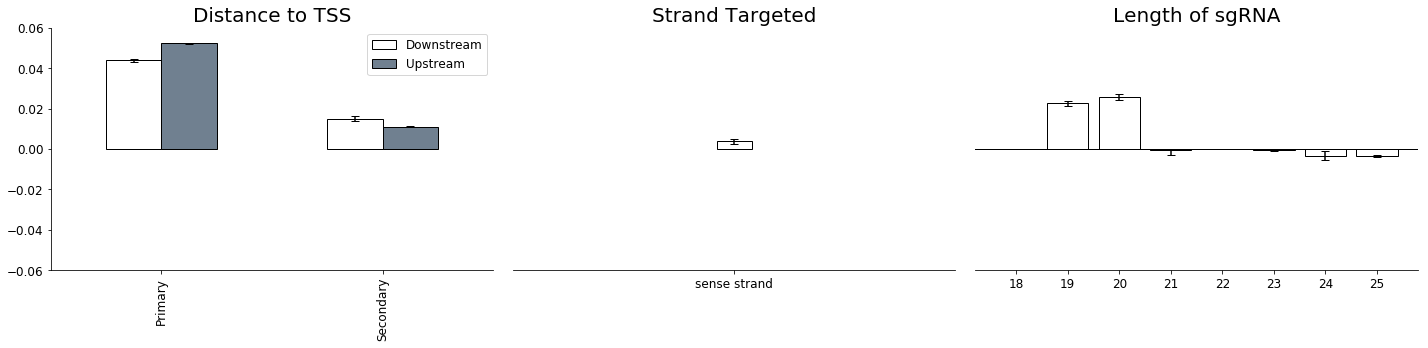

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
plot_TSS(axs[0], True)
plot_strand(axs[1], False)
plot_length(axs[2], False
fig.tight_layout()
plt.savefig("upper")

In [15]:
# Regular expression which returns a boolean if the column name is for a nucleotide position
def find_nucl_pos(string):
    prog = re.compile('pos_-[0-9]+_[A-Z]$')
    result = prog.match(string)
    return bool(result)

In [16]:
# Regular expression which returns a boolean if the column name is for a dimer position
def find_dimer_pos(string):
    prog = re.compile('pos_-[0-9]+_[A-Z][A-Z]$')
    result = prog.match(string)
    return bool(result)

In [17]:
nucl_pos_bool = [find_nucl_pos(name) for name in cols]
dimer_pos_bool = [find_dimer_pos(name) for name in cols]

In [18]:
def get_pos(string):
    return -1 * int(re.findall('[0-9]+', string)[0])

In [19]:
# Extract out position elements
nucl_pos_names = cols[nucl_pos_bool]
nucl_pos = [get_pos(name) for name in nucl_pos_names]

dimer_pos_names = cols[dimer_pos_bool]
dimer_pos = [get_pos(name) for name in dimer_pos_names]

In [20]:
nucl_coef = coef[:, nucl_pos_bool]
dimer_coef = coef[:, dimer_pos_bool]

In [21]:
def specific_nucl_pos(nucleotide):
    pos_bool = [nucleotide in name for name in nucl_pos_names]
    names = nucl_pos_names[pos_bool]
    pos = [get_pos(name) for name in names]
    coef = nucl_coef[:, pos_bool]
    return (names, pos, coef)

In [22]:
A = specific_nucl_pos('A')
C = specific_nucl_pos('C')
G = specific_nucl_pos('G')
T = specific_nucl_pos('T')
nucl_pos_plot = [A, C, G, T]

In [23]:
def pos_plot(plot_info, colors, title, legend, ax):
    width = 1/len(plot_info)
    for index, nucl in enumerate(plot_info):
        ax.bar(np.array(nucl[1]) + (index - 1)*width, nucl[2][0] + 0.001, width, 
               yerr = [nucl[2][1], nucl[2][2]], 
               ecolor = colors[index],
               color = colors[index])
    ax.legend(legend, loc='upper left', ncol=4)
    ax.set_xticks((-1 * np.arange(len(nucl[1])) - 3))
    ax.set_ylim((-0.06, 0.06))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=20)

In [24]:
def specific_dimer_pos(dimer):
    pos_bool = [dimer in name for name in dimer_pos_names]
    names = dimer_pos_names[pos_bool]
    pos = [get_pos(name) for name in names]
    curr_coef = dimer_coef[:, pos_bool]
    return (names, pos, curr_coef)

In [25]:
dimer_encodings = {'AA' : 0, 'AC' : 1, 'AG' : 2, 'AT' : 3, 'CA' : 4, 'CC' : 5, 'CG' : 6, 'CT' : 7,          
                   'GA' : 8, 'GC' : 9, 'GG' : 10, 'GT' : 11, 'TA' : 12, 'TC' : 13, 'TG' : 14, 'TT' : 15}
dimers = dimer_encodings.keys()
dimer_plot = []
for dimer in dimers:
    dimer_plot.append(specific_dimer_pos(dimer))

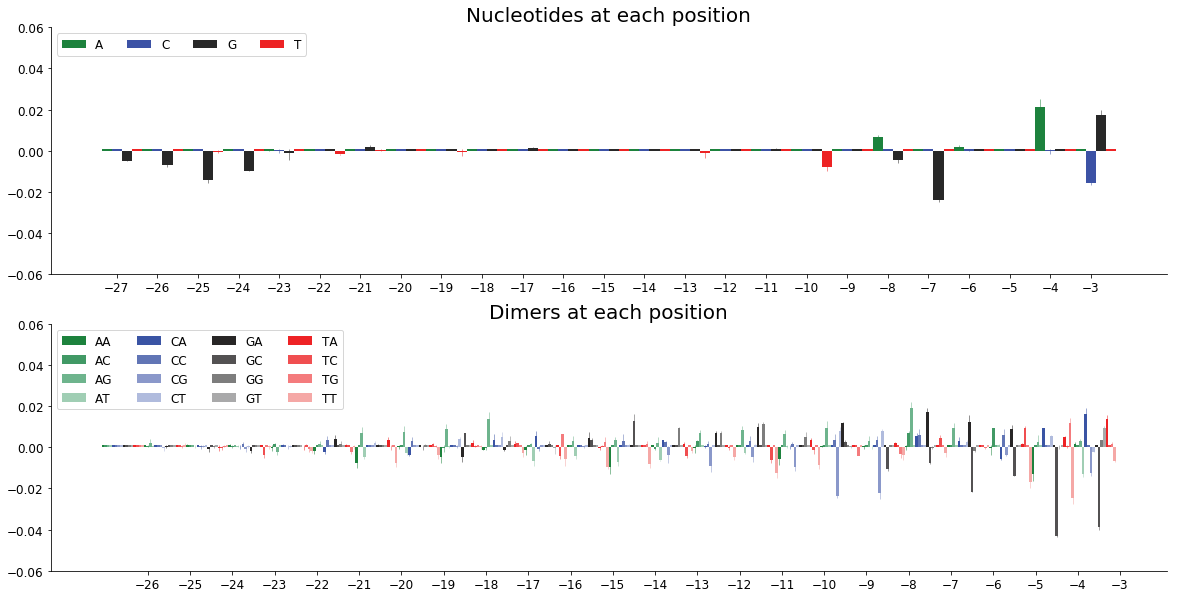

In [26]:
plt.rcParams.update({'lines.linewidth': 0.5}) # make error bars thin

f, axs = plt.subplots(2, 1,figsize=(20,10))
colors =  ['#1d823d', '#3c52a5', '#282828', '#ed2324']
pos_plot(nucl_pos_plot, colors, "Nucleotides at each position", ('A', 'C', 'G', 'T'), axs[0])
colors = ['#1d823d', '#419965', '#6eb48d', '#a0ceb4',
         '#3a54a4', '#6175b5', '#8a98ca','#b0bbdd',
         '#282626', '#535152', '#7d7d7d', '#a9a9aa',
         '#ee2225', '#f04e50', '#f47b7d', '#f5a8a6']
pos_plot(dimer_plot, colors,"Dimers at each position", dimers, axs[1])

plt.rcParams.update({'lines.linewidth': 1.5})
plt.savefig("per_position")

In [27]:
def longest_run(nucl, ax, color, first):
    dist_indices = ['longest_' + nucl in colname for index, colname in enumerate(cols)]
    dist_name = cols[dist_indices]
    dist_coef = coef[0, dist_indices]
    dist = [get_run(name) for name in dist_name]
    ax.bar(dist, dist_coef, 
           yerr = coef[1:, dist_indices], 
           capsize=4, ecolor='k',
           color = color, edgecolor='k')
    ax.set_ylim((-0.06, 0.06))
    ax.axhline(linewidth = 1, color = 'k')
    set_graph(first, ax)
    ax.set_title('Longest run of ' + nucl, fontsize=20)

In [28]:
def find_comp(string, nucl):
    prog = re.compile('^' + nucl + '_comp')
    result = prog.match(string)
    return bool(result)

In [29]:
def composition(nucl, ax, color, first):
    dist_indices = [find_comp(colname, nucl) for index, colname in enumerate(cols)]
    dist_name = cols[dist_indices]
    dist_coef = coef[0, dist_indices]
    dist = [name[-3:] for name in dist_name]
    ax.bar(dist, dist_coef, yerr = coef[1:, dist_indices], 
           capsize=4, ecolor='k',
           color = color, edgecolor='k')
    ax.set_ylim((-0.06, 0.06))
    ax.axhline(linewidth = 1, color = 'k')
    set_graph(first, ax)
    ax.set_title('Composition of ' + nucl, fontsize=20)

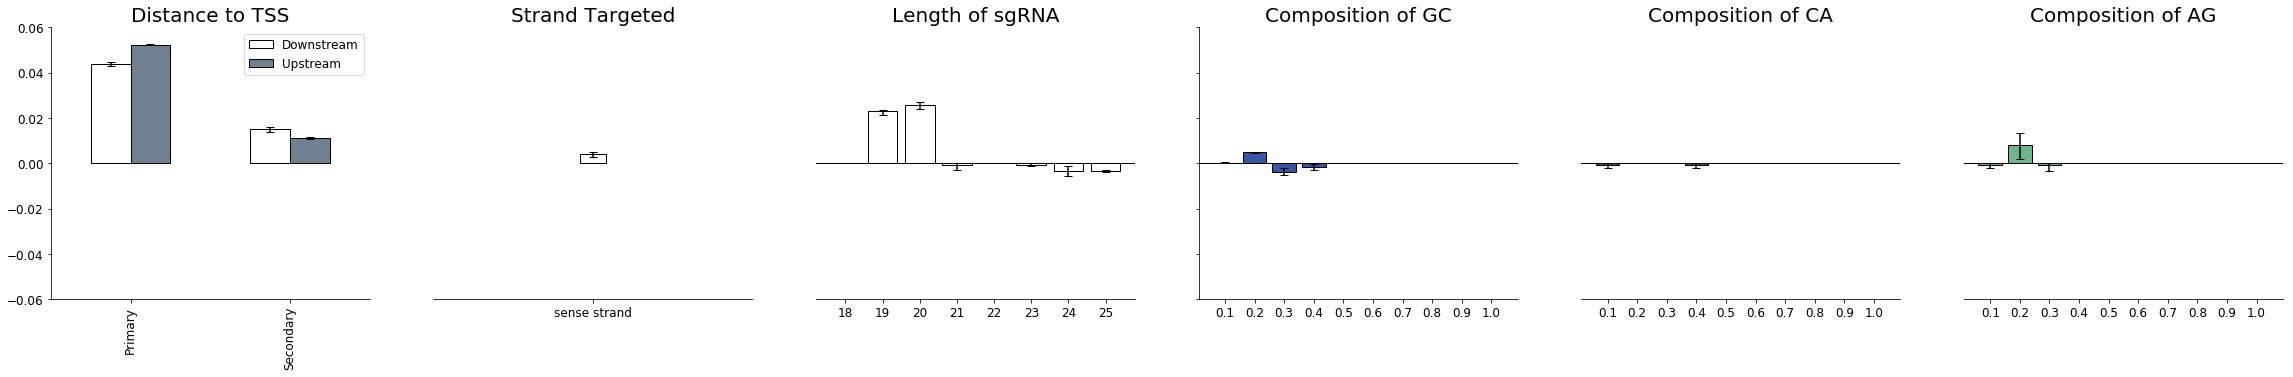

In [32]:
f, axs = plt.subplots(1,6,figsize=(40,5))

plot_TSS(axs[0], True)
plot_strand(axs[1], False)
plot_length(axs[2], False)

colors = ['#3a54a4', '#535152', '#6eb48d']
for nucl, ax, color in [('GC', axs[3], colors[0]), 
                ('CA', axs[4], colors[1]),
                ('AG', axs[5], colors[2])]:
    if(ax == axs[3]):
        composition(nucl, ax, color, True)
    else:
        composition(nucl, ax, color, False)
    
# hide outer axes 
for ax in axs.flat:
    ax.label_outer()
    
plt.savefig("dimer_comp")

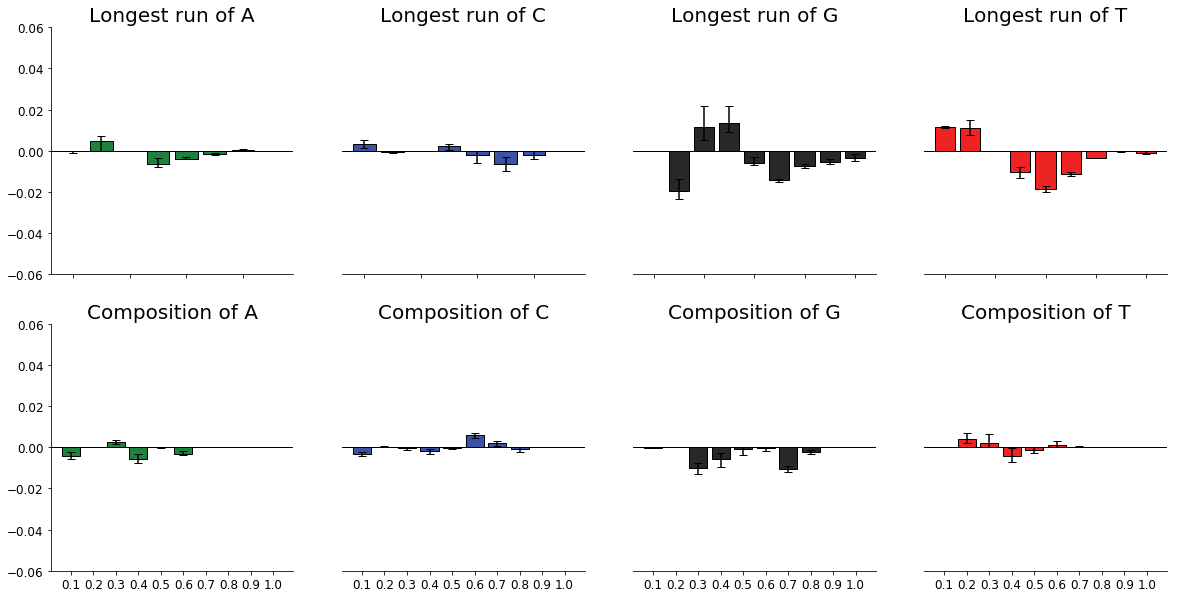

In [31]:
f, axs = plt.subplots(2,4,figsize=(20,10))

colors = ['#1d823d', '#3c52a5', '#282828', '#ed2324']
for nucl, ax_run, ax_comp, color in [('A', axs[0, 0], axs[1, 0], colors[0]), 
                ('C', axs[0, 1], axs[1, 1], colors[1]),
                ('G', axs[0, 2], axs[1, 2], colors[2]),
                ('T', axs[0, 3], axs[1, 3], colors[3])]:
    if(ax_run == axs[0, 0]):
        longest_run(nucl, ax_run, color, True)
        composition(nucl, ax_comp, color, True)
    else:
        longest_run(nucl, ax_run, color, False)
        composition(nucl, ax_comp, color, False)

# hide outer axes 
for ax in axs.flat:
    ax.label_outer()
    
fig.tight_layout()

plt.savefig("run_comp")

In [35]:
import matplotlib.gridspec as gridspec

In [36]:
fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(6, 12)

f3_ax1 = fig3.add_subplot(gs[0, :])
colors =  ['#1d823d', '#3c52a5', '#282828', '#ed2324']
pos_plot(nucl_pos_plot, colors, "Nucleotides at each position", ('A', 'C', 'G', 'T'), f3_ax1)

f3_ax2 = fig3.add_subplot(gs[1, :])
colors = ['#1d823d', '#419965', '#6eb48d', '#a0ceb4',
         '#3a54a4', '#6175b5', '#8a98ca','#b0bbdd',
         '#282626', '#535152', '#7d7d7d', '#a9a9aa',
         '#ee2225', '#f04e50', '#f47b7d', '#f5a8a6']
pos_plot(dimer_plot, colors,"Dimers at each position", dimers, f3_ax2)

longA_ax = fig3.add_subplot(gs[2, :2])
longC_ax = fig3.add_subplot(gs[2, 2:5])
longG_ax = fig3.add_subplot(gs[2, 5:8])
longT_ax = fig3.add_subplot(gs[2, 8:11])

compA_ax = fig3.add_subplot(gs[3, :2])
compC_ax = fig3.add_subplot(gs[3, 2:5])
compG_ax = fig3.add_subplot(gs[3, 5:8])
compT_ax = fig3.add_subplot(gs[3, 8:11])

colors = ['#1d823d', '#3c52a5', '#282828', '#ed2324']
for nucl, ax_run, ax_comp, color in [('A', longA_ax, compA_ax, colors[0]), 
                ('C', longC_ax, compC_ax, colors[1]),
                ('G', longG_ax, compG_ax, colors[2]),
                ('T', longT_ax, compT_ax, colors[3])]:
    if(ax_run == axs[0, 0]):
        longest_run(nucl, ax_run, color, True)
        composition(nucl, ax_comp, color, True)
    else:
        longest_run(nucl, ax_run, color, False)
        composition(nucl, ax_comp, color, False)
        
compGC_ax = fig3.add_subplot(gs[4, :3])
compCA_ax = fig3.add_subplot(gs[4, 3:7])
compAG_ax = fig3.add_subplot(gs[4, 7:11])

colors = ['#3a54a4', '#535152', '#6eb48d']
for nucl, ax, color in [('GC', compGC_ax, colors[0]), 
                ('CA', compCA_ax, colors[1]),
                ('AG', compAG_ax, colors[2])]:
    if(ax == axs[3]):
        composition(nucl, ax, color, True)
    else:
        composition(nucl, ax, color, False)
 
TSS_ax = fig3.add_subplot(gs[5, :3])
strand_ax = fig3.add_subplot(gs[5, 3:7])
len_ax = fig3.add_subplot(gs[5, 7:11])
plot_TSS(TSS_ax, True)
plot_strand(strand_ax, False)
plot_length(len_ax, False)



AttributeError: 'Figure' object has no attribute 'add_gridspec'

<Figure size 432x288 with 0 Axes>